In [14]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [15]:
path_csv = '/home/paul/workspace/postdoc-year1/projects/calprotectin/data/Sepsis_Validation_FINAL DATASET_110925_SH.xlsx'
df = pd.read_excel(path_csv)
# drop the one NaN from IL6
# df_cleaned = df.dropna(subset=['IL6_value_1', 'fever_sub_partu', 'b_streptococcus']).copy()
# df_cleaned.shape

In [16]:
df.shape

(355, 58)

In [17]:
keys = ['birth_weight', 'gest_weeks', 'age_mother', 'gravidity', 'parity', 'birth_mode', 'umbilical_cord_ph',
       'capillary_time', 'o2_demand', 'breath_aid', 'heart_rate',
       'respiration_rate', 'rr_systolic', 'rr_diastolic', 'base_excess',
       'ph_value', 'antibiotic_therapy', 'antibiotic_therapy_duration',
       'diagnosis_infection', 'result_blood_culture', 'gestation_diabetes',
       'diabetes_type_1_2', 'adiposity', 'early_membrane_rupture',
       'membrane_rupture_hours', 'early_labor_pain', 'green_amniotic_liquor',
       'b_streptococcus', 'crp_max_prepartal',
       'leukocyte_max_prepartal', 'fever_sub_partu', 'antibiotics_prepartal',
       'crp_time_1', 'crp_value_1', 'crp_time_2', 'crp_value_2', 'crp_time_3',
       'crp_value_3', 'crp_time_4', 'crp_value_4', 'crp_time_5', 'crp_value_5',
       'IL6_time_1', 'IL6_value_1', 'Cal_time_1', 'Cal_value_1', 'Cal_time_2',
       'Cal_value_2', 'Cal_time_3', 'Cal_value_3', 'Cal_time_4', 'Cal_value_4',
       'Cal_time_5', 'Cal_value_5']

In [18]:
null_counts = df[keys].isnull().sum()

# Filter to show only columns with missing values
# null_counts = null_counts[null_counts > 0]

print("Columns with missing values:")
print(null_counts)

Columns with missing values:
birth_weight                     0
gest_weeks                       1
age_mother                       0
gravidity                        3
parity                           2
birth_mode                       0
umbilical_cord_ph                3
capillary_time                  12
o2_demand                        0
breath_aid                       0
heart_rate                       1
respiration_rate                 5
rr_systolic                      4
rr_diastolic                     4
base_excess                     17
ph_value                        13
antibiotic_therapy               0
antibiotic_therapy_duration    115
diagnosis_infection              0
result_blood_culture            29
gestation_diabetes               2
diabetes_type_1_2                2
adiposity                        2
early_membrane_rupture           2
membrane_rupture_hours         227
early_labor_pain                 3
green_amniotic_liquor            3
b_streptococcus           

In [19]:
keys_cleaned = ['birth_weight', 'gest_weeks', 'age_mother', 'gravidity', 'parity', 'umbilical_cord_ph',
       'o2_demand', 'breath_aid', 'heart_rate',
       'respiration_rate', 'rr_systolic', 'rr_diastolic', 'base_excess',
       'ph_value', 'antibiotic_therapy',
       'diagnosis_infection', 'gestation_diabetes',
       'diabetes_type_1_2', 'adiposity', 'early_membrane_rupture',
       'early_labor_pain', 'green_amniotic_liquor',
       'b_streptococcus',
       'fever_sub_partu', 'antibiotics_prepartal',
       'crp_value_1', 'IL6_time_1', 'IL6_value_1', 'Cal_value_1']

In [20]:
df_cleaned = df.dropna(subset=keys_cleaned).copy()
df_cleaned.shape

(324, 58)

In [21]:
features_clinical = ['birth_weight', 'gest_weeks', 'age_mother', 'gravidity', 'parity', 'umbilical_cord_ph',
       'o2_demand', 'breath_aid', 'heart_rate',
       'respiration_rate', 'rr_systolic', 'rr_diastolic', 'base_excess',
       'ph_value', 'gestation_diabetes',
       'diabetes_type_1_2', 'adiposity', 'early_membrane_rupture',
       'early_labor_pain', 'green_amniotic_liquor',
       'b_streptococcus',
       'fever_sub_partu', 'antibiotics_prepartal']
features_biomarkers_classic = ['crp_value_1', 'IL6_value_1']
feature_cal = ['Cal_value_1']
target = 'diagnosis_infection'
all_features = features_clinical + features_biomarkers_classic + feature_cal

In [22]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df_cleaned, test_size=0.2, random_state=42, stratify=df_cleaned[target])
X_train = train_df[features_clinical + feature_cal]
y_train = train_df[target]
X_test = test_df[features_clinical + feature_cal]
y_test = test_df[target]

In [23]:
preprocessor = StandardScaler()

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, class_weight='balanced'))
])

In [24]:
model_pipeline.fit(X_train, y_train)

# Evaluate on the unseen TEST set
y_pred_test = model_pipeline.predict(X_test)
y_pred_proba_test = model_pipeline.predict_proba(X_test)[:, 1]

print("\nPerformance on the Test Set (Expanded Features):")
print(f"Test Set ROC AUC Score: {roc_auc_score(y_test, y_pred_proba_test):.4f}")
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred_test))


Performance on the Test Set (Expanded Features):
Test Set ROC AUC Score: 0.7578

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.82      0.73      0.78        45
           1       0.52      0.65      0.58        20

    accuracy                           0.71        65
   macro avg       0.67      0.69      0.68        65
weighted avg       0.73      0.71      0.72        65



In [26]:
coefficients = pd.DataFrame(
    model_pipeline.named_steps['classifier'].coef_[0], 
    index=features_clinical + feature_cal, 
    columns=['Coefficient']
)
coefficients.sort_values('Coefficient', ascending=False, inplace=True)

print("\n--- Expanded Model Feature Importance ---")
print(coefficients)


--- Expanded Model Feature Importance ---
                        Coefficient
o2_demand                  0.581403
Cal_value_1                0.467267
birth_weight               0.412987
respiration_rate           0.327957
rr_systolic                0.202072
green_amniotic_liquor      0.193285
gestation_diabetes         0.185281
gravidity                  0.143119
b_streptococcus            0.124244
heart_rate                 0.111774
antibiotics_prepartal      0.096341
base_excess               -0.013816
ph_value                  -0.043061
fever_sub_partu           -0.060532
early_labor_pain          -0.077467
breath_aid                -0.110488
umbilical_cord_ph         -0.122366
rr_diastolic              -0.181329
adiposity                 -0.227329
parity                    -0.231669
early_membrane_rupture    -0.236912
gest_weeks                -0.270384
diabetes_type_1_2         -0.382711
age_mother                -0.425074


Confusion Matrix (Test Set):


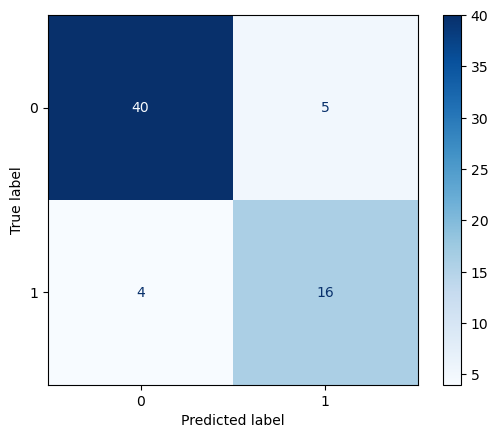

In [ ]:
print("Confusion Matrix (Test Set):")
ConfusionMatrixDisplay.from_estimator(model_pipeline, X_test, y_test, cmap='Blues')
plt.show()